In [ ]:
# -*- coding: utf-8 -*-
"""

This script performs the following tasks:

1. Uses as input the weights from a run of the Convolutional Variational Autoencoder (CVAE) from the TensorFlow tutorial.
2. Uses as input the latent space of the MNIST dataset encoded through CVAE.

The script implements both the encoder and decoder as functions.

Authors:
- Gabriel Turinici
- Tiffany Zeitoun
- Dan Winzsman
- Benjamin Krief
"""

# Import necessary libraries for deep learning, visualization, and data processing
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # For displaying progress bars during training or data loading
import pandas as pd  # For handling data operations and analysis

In [ ]:
# Print a message indicating the download process is starting
print('Downloading necessary files')

# Import the requests library for handling file downloads
import requests

# Base URL for downloading the required files
base_url = 'https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/'

# List of file names to be downloaded
files_names = ['my_checkpoint.index', 'reparam.npz', 'my_checkpoint.data-00000-of-00001']

# Loop through the list of files and download each one
for fl in files_names:
    print(f'Downloading {fl} from {base_url}')  # Inform the user which file is being downloaded
    response = requests.get(base_url + fl)  # Send a request to download the file
    with open(fl, mode="wb") as file:  # Open the file in write-binary mode
        file.write(response.content)  # Write the downloaded content to the file


download necessary files
downloading my_checkpoint.index from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading reparam.npz from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/
downloading my_checkpoint.data-00000-of-00001 from https://github.com/gabriel-turinici/Huber-energy-measure-quantization/raw/main/diversity_in_generative_ai/


In [ ]:
def preprocess_images(images):
    """
    Preprocess the input images by reshaping and normalizing pixel values.

    Args:
        images (numpy array): Array of images to be preprocessed.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1) and normalized to float32.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel)
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0  # Normalize pixel values to [0, 1] range
    
    return images.astype('float32')


In [ ]:
# Load and preprocess the MNIST dataset
print('Loading MNIST dataset and preprocessing images')

# Load the MNIST dataset from TensorFlow's built-in datasets (we only need the images, not the labels)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# Define a function to preprocess MNIST images
def preprocess_images(images):
    """
    Preprocess the input images by reshaping, normalizing, and binarizing pixel values.

    Args:
        images (numpy array): Array of images to preprocess.

    Returns:
        numpy array: Preprocessed images, reshaped to (28, 28, 1), normalized and binarized.
    """
    # Reshape the images to add a channel dimension (28x28 images with 1 channel) and normalize pixel values
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.0

    # Binarize pixel values: set values > 0.5 to 1.0 and others to 0.0
    return np.where(images > 0.5, 1.0, 0.0).astype('float32')

# Preprocess the training and testing images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Display the shape of the preprocessed training images
print('Shape of preprocessed train_images:', train_images.shape)


load mnist, preprocess images
train_image.shape= (60000, 28, 28, 1)


In [ ]:
N = 2  # Ambient dimension for latent space

class CVAE(tf.keras.Model):
    """Convolutional Variational Autoencoder (CVAE) class definition."""

    def __init__(self, latent_dim):
        """
        Initialize the CVAE model.
        
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the encoder network as a Sequential model
        self.encoder = tf.keras.Sequential(
            [
                # Input layer: shape of the input is (28, 28, 1) for MNIST images
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                
                # Flatten the input image into a 1D vector
                tf.keras.layers.Flatten(),
                
                # Add 5 fully connected layers with ReLU activation
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(5)],
                
                # The final layer outputs both mean and log variance for reparameterization
                tf.keras.layers.Dense(latent_dim + latent_dim)  # Output latent_dim for mean and logvar
            ]
        )

        # Define the decoder network as a Sequential model
        self.decoder = tf.keras.Sequential(
            [
                # Input layer: latent space input of shape (latent_dim,)
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

                # Flatten the latent vector (though it's already 1D in this case)
                tf.keras.layers.Flatten(),

                # Add fully connected layers to reconstruct the original image
                *[tf.keras.layers.Dense(28 * 28, activation='relu') for _ in range(4)],

                # The final layer reshapes the output back to (28, 28, 1) for the image
                tf.keras.layers.Dense(28 * 28),  # Output logits without activation
                tf.keras.layers.Reshape((28, 28, 1))  # Reshape the output to match the original image size
            ]
        )

    @tf.function
    def sample(self, eps=None):
        """
        Generate samples from the latent space by decoding random or given points.

        Args:
            eps (tensor, optional): Latent space points. If not provided, random points are sampled.
        
        Returns:
            tensor: Decoded output from latent space points, typically images.
        """
        if eps is None:
            # If no latent points are provided, generate random points from a normal distribution
            eps = tf.random.normal(shape=(100, self.latent_dim))
        
        # Decode the latent space points into images
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        """
        Encodes the input images into the latent space.
        
        Args:
            x (tensor): Input image data.
        
        Returns:
            tuple: Mean and log variance of the encoded latent variables.
        """
        # Split the encoder output into mean and log variance for the latent space
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """
        Reparameterization trick to sample from a normal distribution using the mean and log variance.
        
        Args:
            mean (tensor): Mean of the latent variables.
            logvar (tensor): Log variance of the latent variables.
        
        Returns:
            tensor: Sampled latent variables.
        """
        # Sample random noise from a standard normal distribution
        eps = tf.random.normal(shape=mean.shape)
        
        # Reparameterize to generate latent variables
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        """
        Decodes the latent variables back into images.
        
        Args:
            z (tensor): Latent variables.
            apply_sigmoid (bool, optional): Whether to apply the sigmoid function to the output.
        
        Returns:
            tensor: Decoded output, typically images.
        """
        # Pass the latent variables through the decoder network to reconstruct images
        logits = self.decoder(z)

        # Apply sigmoid activation if specified (useful for binary outputs)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        
        return logits  # Return the raw logits if no sigmoid is applied


In [ ]:
latent_dim = 2  # Set the dimensionality of the latent space

# Create a new instance of the CVAE model
print('Creating a new CVAE model instance')
model = CVAE(latent_dim)

# Generate a sample from the model using a random latent vector
res = model.sample(np.random.randn(1, latent_dim))  # Sampling from a random latent vector

# Uncomment the following line if you want to generate and save images using a custom function
# generate_and_save_images(model, 0, test_sample)

# Set the model's 'built' attribute to True to allow loading weights
model.built = True

# Restore the model weights from a checkpoint
print('Restoring model weights from checkpoint')

# Ensure that you are in the correct directory where the "my_checkpoint.index" file is located
model.load_weights("./my_checkpoint")


Create a new model instance
restore weights


In [ ]:
def decoder_function(latent, digit_size=28):
    """
    Decoder function: Takes a latent vector as input and outputs a 28x28 image.
    
    Args:
        latent (tensor): Latent vector of shape (latent_dim,).
        digit_size (int): Size of the output image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Decoded image of shape (digit_size, digit_size).
    """
    # Ensure the latent vector has the correct shape
    assert latent.shape == (latent_dim,), 'Error: input latent vector has incorrect shape'
    
    # Pass the latent vector through the model's decoder to generate the image
    x_decoded = model.sample(latent[None, :])  # Add batch dimension
    
    # Reshape the output into a 28x28 image
    digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
    
    return digit


def encoder_function(image, digit_size=28):
    """
    Encoder function: Takes an image as input and outputs a latent vector.
    
    Args:
        image (tensor): Input image of shape (digit_size, digit_size).
        digit_size (int): Size of the input image, default is 28 (for 28x28 image).
    
    Returns:
        tensor: Latent vector of shape (latent_dim,).
    """
    # Ensure the input image has the correct shape
    assert image.shape == (digit_size, digit_size), 'Error: input image has incorrect shape'
    
    # Reshape the image to add the necessary batch and channel dimensions, then pass through the encoder
    res = model.encoder(tf.reshape(image, (1, digit_size, digit_size, 1)))  # Add batch and channel dimensions
    
    # Return the latent vector (taking only the first 'latent_dim' values)
    return res[0, :latent_dim]


In [ ]:
# Adjust the display options for NumPy arrays
np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # Ensures full array output without truncation

# Load the NumPy array from the 'reparam.npz' file
with np.load('reparam.npz', allow_pickle=True) as data:
    reparam = data['reparam']  # Extract the 'reparam' array from the file

# Uncomment the line below if you wish to print the entire first element of the array
# print(reparam[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

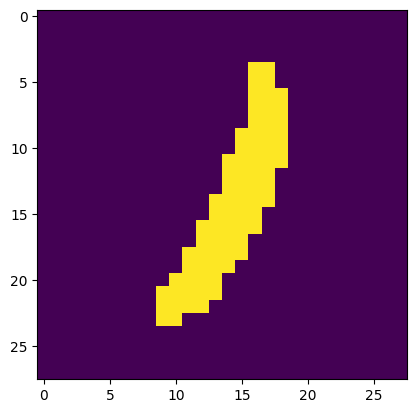

In [ ]:
# Define the index of the MNIST image to display
mnist_index = 78

# Print the pixel values of the MNIST image at the specified index
print(train_images[mnist_index, :, :, 0])

# Display the MNIST image using matplotlib's imshow function
plt.imshow(train_images[mnist_index, :, :, 0], cmap='gray')  # Display in grayscale for better visibility
plt.title(f"MNIST Image at Index {mnist_index}")  # Add a title to the plot
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()  # Display the plot


Mounted at /content/drive


<Figure size 640x480 with 0 Axes>

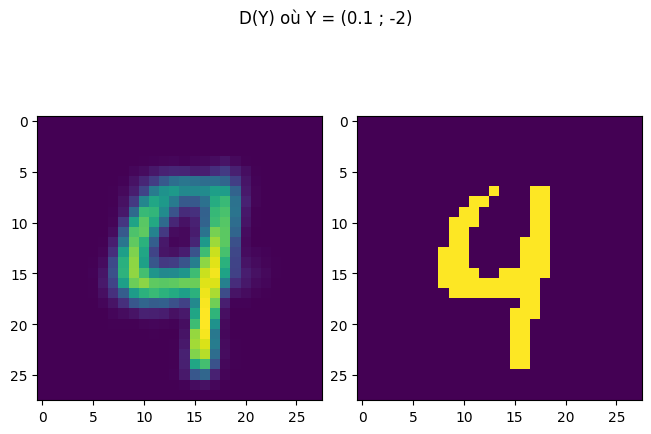

In [ ]:
from google.colab import files
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

def trained_overview(mnist_index, file_path_overview='', save=False):
    """
    Display a comparison of decoded images and optionally save the plot.

    Args:
        mnist_index (int): Index of the MNIST image to process.
        file_path_overview (str): Path to save the image plot, if save is True.
        save (bool): Whether to save and download the plot.
    """
    # Create a figure with constrained layout for better spacing
    plt.figure(constrained_layout=True)
    
    # Encode the selected MNIST image and then decode the latent vector
    res_l2 = encoder_function(train_images[mnist_index, :, :, 0])  # Encode the image
    res_i2 = decoder_function(res_l2)  # Decode the encoded image
    
    # Decode a predefined latent vector (for testing diversity)
    res_i = decoder_function(np.array([0.1, -2]))

    ####################################################################################################################################################
    # Subplot 1: Display the decoded image from the predefined latent vector
    ####################################################################################################################################################
    plt.subplot(1, 2, 1)
    plt.imshow(res_i, cmap='gray')  # Display in grayscale
    plt.title(f"Decoded Image (Y = [0.1, -2])")  # Title indicating the latent vector used

    ####################################################################################################################################################
    # Subplot 2: Display the binarized version of the decoded image
    ####################################################################################################################################################
    plt.subplot(1, 2, 2)
    plt.imshow(np.where(res_i > 0.5, 1.0, 0.0), cmap='gray')  # Binarize the image based on pixel values
    plt.title(f"Binarized Decoded Image")  # Title for the binarized image

    # Add a general title for the entire figure
    plt.suptitle("Comparison of Decoded Images")

    # Save the plot to the specified file path if 'save' is True
    if save:
        plt.savefig(file_path_overview)

    # Display the plot
    plt.show()

    # Download the file if 'save' is True
    if save:
        files.download(file_path_overview)

# Example usage
if __name__ == "__main__":
    mnist_index = 30000  # Define the index of the MNIST image to process
    file_name_overview = 'lack_of_diversity.pdf'  # Define the file name for saving
    file_path_overview = f"/content/drive/My Drive/Thesis/{file_name_overview}"  # Full file path for saving
    save = False  # Set to True if you want to save the plot
    trained_overview(mnist_index, file_path_overview, save)  # Call the function


In [ ]:
# Import necessary libraries for deep learning, plotting, and file handling
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from tqdm import tqdm
from google.colab import files
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')


def gradient_descent(mnist_index, file_path_loss_function="", save=False):
    """
    Perform gradient descent on the latent vector to minimize the reconstruction loss for a given MNIST image.

    Args:
        mnist_index (int): Index of the MNIST image to be trained.
        file_path_loss_function (str): Path to save the loss plot if save is True.
        save (bool): If True, saves the loss plot and downloads it.

    Returns:
        tuple: Final loss, percentage change in loss (delta), and the optimized latent vector (solution).
    """
    latent_dim = 2  # Dimensionality of the latent space
    learning_rate = 1e-3  # Learning rate for the optimizer

    # Define the optimizer (Adafactor in this case)
    optimizer = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)

    # Store the training losses
    losses = []

    # Get the target MNIST image at the specified index
    image_cible = train_images[mnist_index, :, :, 0]  # Target MNIST image

    # Initialize the latent vector 'y' using the encoder output
    y = tf.Variable(tf.convert_to_tensor(encoder_function(image_cible)))

    epochs = 150  # Number of training epochs

    # Perform gradient descent for the specified number of epochs
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Calculate the loss (L2 loss between the target image and the decoded image)
            loss = tf.reduce_sum(tf.square(image_cible - decoder_function(y)))
            losses.append(loss)

            # Compute gradients and apply them to update the latent vector 'y'
            gradients = tape.gradient(loss, [y])
            optimizer.apply_gradients(zip(gradients, [y]))

    if save:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label='Train Loss')
        plt.title(f'Loss evolution during the training of image {mnist_index}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Optional: save and download the loss plot
        # plt.savefig(file_path_loss_function)
        # files.download(file_path_loss_function)

    # Calculate the final loss, the first loss, and the percentage change (delta)
    final_loss = losses[99].numpy()  # Final loss
    first_loss = losses[0].numpy()   # Initial loss
    delta = ((final_loss - first_loss) / first_loss) * 100  # Percentage change in loss
    solution = y.numpy()  # Optimized latent vector

    return final_loss, delta, solution


def create_list_sub_txt(huge_list, filepath=''):
    """
    Write a list of lists to a text file.

    Args:
        huge_list (list of lists): List containing sublists.
        filepath (str): Path to the file for saving the sublists.
    """
    with open(filepath, 'w') as file:
        for sublist in huge_list:
            file.write('[' + ', '.join(map(str, sublist)) + ']\n')


def create_list_txt(simple_list, filepath=''):
    """
    Write a simple list to a text file.

    Args:
        simple_list (list): List of values to save.
        filepath (str): Path to the file for saving the list.
    """
    with open(filepath, 'w') as file:
        file.write(', '.join(map(str, simple_list)) + '\n')


# Example usage
if __name__ == "__main__":
    mnist_index = 55  # Define the index of the MNIST image to process
    save = False  # Set to True if you want to save the loss plot

    # File path for saving the loss plot
    file_name_loss_function = f"loss_function_image_{mnist_index}_new.pdf"
    file_path_loss_function = f"/content/drive/My Drive/Thesis/image_{mnist_index}/{file_name_loss_function}"

    # Measure execution time for gradient descent
    start_time = time.time()
    result = gradient_descent(mnist_index, file_path_loss_function, save)
    end_time = time.time()

    # Print the execution time and the results
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds.")
    print(result)

    # Uncomment the following block if you want to process multiple images:
    # nb_images = 5000
    # final_errors = []
    # deltas = []
    # solutions = []
    # for i in tqdm(range(nb_images)):
    #     result = gradient_descent(i, file_path_loss_function, save)
    #     final_errors.append(result[0])
    #     deltas.append(result[1])
    #     solutions.append(result[2].tolist())
    
    # Save the results to text files:
    # filepath_final_errors = '/content/drive/My Drive/Thesis/data/final_errors.txt'
    # filepath_deltas = '/content/drive/My Drive/Thesis/data/deltas.txt'
    # filepath_solutions = '/content/drive/My Drive/Thesis/data/solutions.txt'
    # create_list_txt(final_errors, filepath_final_errors)
    # create_list_txt(deltas, filepath_deltas)
    # create_list_sub_txt(solutions, filepath_solutions)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le temps d'exécution est de 2.6154160499572754 secondes.
(41.72226, -1.8765507265925407, array([-0.7034883 ,  0.45545533], dtype=float32))


In [ ]:
# Import necessary libraries for file handling and Google Drive access
from google.colab import files
from google.colab import drive
import ast
import numpy as np

# Mount Google Drive to access the files
drive.mount('/content/drive')

def recup_solutions(filepath=''):
    """
    Retrieve solutions from a file, parsing each line as a Python object.

    Args:
        filepath (str): Path to the file containing solutions.

    Returns:
        list: A list of parsed solutions from the file.
    """
    with open(filepath, 'r') as file:
        solutions = [ast.literal_eval(line.strip()) for line in file]  # Parse each line to a Python object
    return solutions

def recup_da_floats(filepath):
    """
    Retrieve a list of floats from a comma-separated file.

    Args:
        filepath (str): Path to the file containing floats.

    Returns:
        list: A list of floats parsed from the file.
    """
    with open(filepath, 'r') as file:
        data = file.read().strip().split(',')  # Split file content by commas
        float_list = [float(x) for x in data]  # Convert each element to float
    return float_list

def create_list_sub_txt(huge_list, filepath=''):
    """
    Write a list of sublists to a text file.

    Args:
        huge_list (list of lists): List containing sublists to save.
        filepath (str): Path to the file for saving the sublists.
    """
    with open(filepath, 'w') as file:
        for sublist in huge_list:
            file.write('[' + ', '.join(map(str, sublist)) + ']\n')


# Define file paths for the necessary data
filepath_final_errors = '/content/drive/My Drive/Thesis/data/final_errors.txt'
filepath_deltas = '/content/drive/My Drive/Thesis/data/deltas.txt'
filepath_solutions = '/content/drive/My Drive/Thesis/data/solutions.txt'
filepath_reparam = '/content/drive/My Drive/Thesis/data/reparam.txt'

# Load data from the respective files
final_errors = recup_da_floats(filepath_final_errors)  # List of final errors
deltas = recup_da_floats(filepath_deltas)  # List of deltas
solutions = recup_solutions(filepath_solutions)  # List of solutions (parsed)

# Create a list of sublists and save it to a file
create_list_sub_txt(solutions, filepath_reparam)

# Reload the reparam data from the file as a NumPy array
reparam = np.array(recup_solutions(filepath_reparam))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'numpy.ndarray'>


<ipython-input-29-13946b578aa1>:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


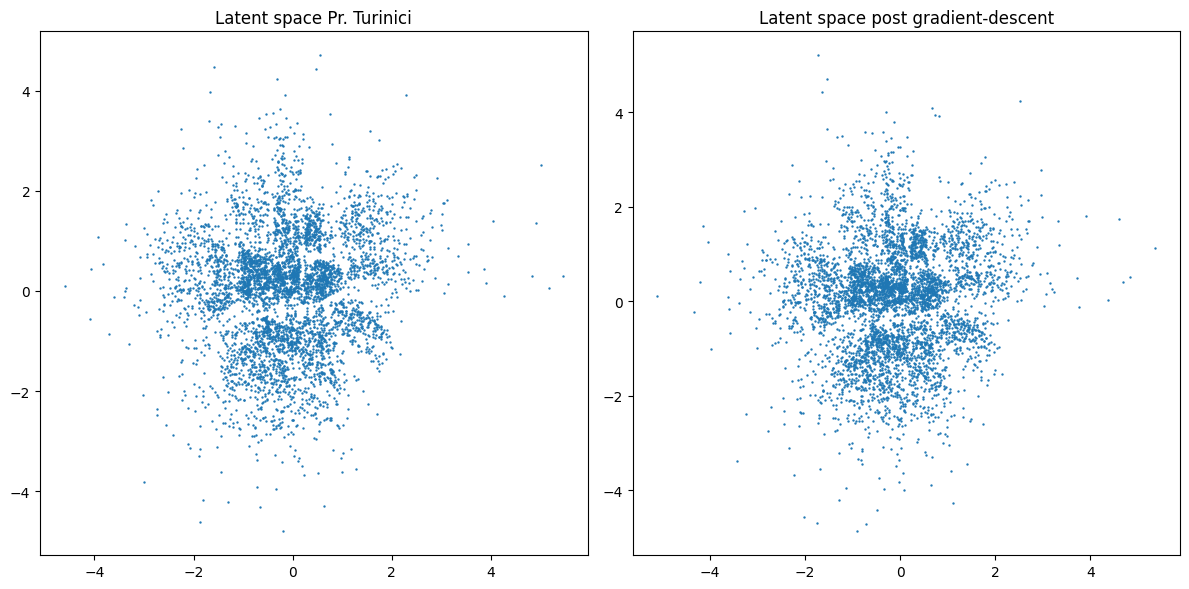

In [ ]:
# Create a figure with constrained layout and specified size
plt.figure(constrained_layout=True, figsize=(12, 6))

####################################################################################################################################################
# Plot for reparam (Pr. Turinici's latent space)
####################################################################################################################################################

plt.subplot(1, 2, 1)

# Use only the first 5000 points from reparam for visualization
reparam_subset = reparam[:5000]

# Randomly select 5000 indices from the subset
rnd_indices = np.random.choice(list(range(reparam_subset.shape[0])), size=5000, replace=False)

# Create the scatter plot for reparam
plt.scatter(reparam_subset[rnd_indices, 0], reparam_subset[rnd_indices, 1], s=0.5)
plt.title("Latent space Pr. Turinici")
plt.tight_layout()

####################################################################################################################################################
# Plot for solutions (post gradient-descent latent space)
####################################################################################################################################################

plt.subplot(1, 2, 2)

# Extract the x and y coordinates from the solutions
x = [point[0] for point in solutions]
y = [point[1] for point in solutions]

# Randomly select 5000 indices from the solutions data
rnd_indices = np.random.choice(list(range(len(solutions))), size=5000, replace=False)

# Create the scatter plot for solutions
plt.scatter(np.array(x)[rnd_indices], np.array(y)[rnd_indices], s=0.5)
plt.title("Latent space post gradient-descent")
plt.tight_layout()

####################################################################################################################################################
# Option to save the plot
####################################################################################################################################################

# Define the path to save the figure
path_location = '/content/drive/My Drive/Thesis/latent_spaces/prev_post_latent_spaces.pdf'

# Uncomment the following line to save the plot to Google Drive
# plt.savefig(path_location)

# Display the plot
plt.show()

# Uncomment the following line to download the saved file from Google Drive
# files.download(path_location)


<ipython-input-14-7c2aeee3a495>:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


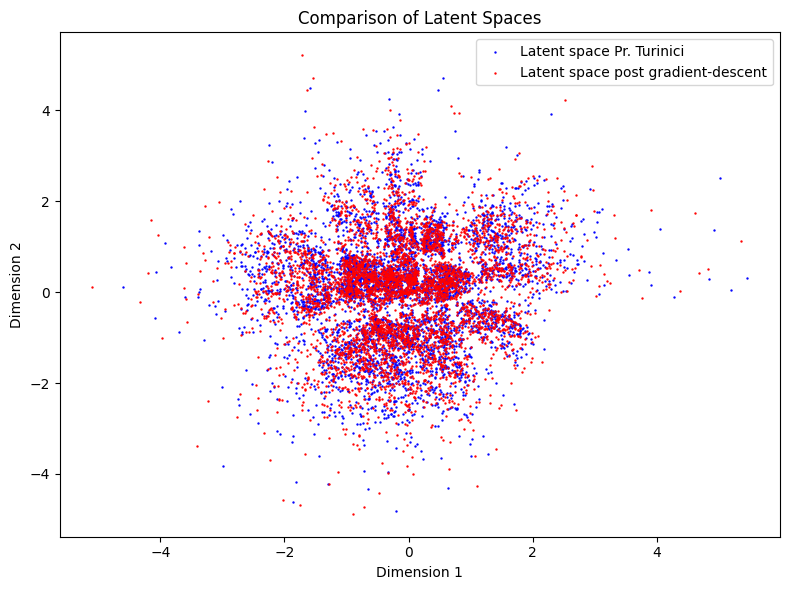

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with constrained layout and a specified size
plt.figure(constrained_layout=True, figsize=(8, 6))

####################################################################################################################################################
# Plot for reparam (Pr. Turinici's latent space)
####################################################################################################################################################

# Use only the first 5000 points from reparam for visualization
reparam_subset = reparam[:5000]

# Randomly select 5000 indices from the subset
rnd_indices = np.random.choice(list(range(reparam_subset.shape[0])), size=5000, replace=False)

# Create a scatter plot for reparam data in blue
plt.scatter(reparam_subset[rnd_indices, 0], reparam_subset[rnd_indices, 1], s=0.5, c='blue', label="Latent space Pr. Turinici")

####################################################################################################################################################
# Plot for solutions (post gradient-descent latent space)
####################################################################################################################################################

# Extract x and y coordinates from the solutions
x = [point[0] for point in solutions]
y = [point[1] for point in solutions]

# Randomly select 5000 indices from the solutions data
rnd_indices = np.random.choice(list(range(len(solutions))), size=5000, replace=False)

# Create a scatter plot for solutions data in red
plt.scatter(np.array(x)[rnd_indices], np.array(y)[rnd_indices], s=0.5, c='red', label="Latent space post gradient-descent")

####################################################################################################################################################
# Customize the plot
####################################################################################################################################################

# Set the plot title and labels for the axes
plt.title("Comparison of Latent Spaces")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add a legend in the upper-right corner
plt.legend(loc='upper right')

# Ensure proper layout adjustment
plt.tight_layout()

####################################################################################################################################################
# Option to save and download the plot
####################################################################################################################################################

# Define the file path to save the plot
path_location = '/content/drive/My Drive/Thesis/latent_spaces/comparison_latent_spaces.pdf'

# Uncomment the following line to save the plot
# plt.savefig(path_location)

# Display the plot
plt.show()

# Uncomment the following line to download the saved plot
# files.download(path_location)


In [1]:
import matplotlib.pyplot as plt

# Create a figure with constrained layout and a specified size
plt.figure(constrained_layout=True, figsize=(8, 6))

####################################################################################################################################################
# Plot for reparam (Pr. Turinici's latent space)
####################################################################################################################################################

# Use only the first 5000 points from reparam for visualization
reparam_subset = reparam[:5000]

# Randomly select 5000 indices from the subset
rnd_indices = np.random.choice(list(range(reparam_subset.shape[0])), size=5000, replace=False)

# Create a scatter plot for reparam data in blue
plt.scatter(reparam_subset[rnd_indices, 0], reparam_subset[rnd_indices, 1], s=0.5, c='blue', label="Latent space Pr. Turinici")

####################################################################################################################################################
# Plot for latent_bonus (Bonus latent space)
####################################################################################################################################################

# Extract x and y coordinates from latent_bonus
a = [point[0] for point in np.array(latent_bonus)]
b = [point[1] for point in np.array(latent_bonus)]

# Randomly select 5000 indices from latent_bonus data
rnd_indices = np.random.choice(list(range(len(latent_bonus))), size=5000, replace=False)

# Create a scatter plot for latent_bonus data in green
plt.scatter(np.array(a)[rnd_indices], np.array(b)[rnd_indices], s=0.5, c='green', label="Latent space Bonus")

####################################################################################################################################################
# Customize the plot
####################################################################################################################################################

# Set the plot title and labels for the axes
plt.title("Comparison of Latent Spaces")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add a legend in the upper-right corner
plt.legend(loc='upper right')

# Ensure proper layout adjustment
plt.tight_layout()

####################################################################################################################################################
# Option to save and download the plot
####################################################################################################################################################

# Define the file path to save the plot
path_location = '/content/drive/My Drive/Thesis/latent_spaces/comparison_latent_spaces_bonus.pdf'

# Uncomment the following line to save the plot
# plt.savefig(path_location)

# Display the plot
plt.show()

# Uncomment the following line to download the saved plot
# files.download(path_location)


NameError: name 'reparam' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Load the reparam data from the 'reparam.npz' file
with np.load('reparam.npz', allow_pickle=True) as data:
    reparam = data['reparam']

# Subset the first 5000 points from reparam
reparam_subset = reparam[:5000]

# Print the mean, variance (covariance matrix), and correlation matrix for the reparam_subset
print('Mean:\n', np.mean(reparam_subset, axis=0))
print('Variance (Covariance Matrix):\n', np.cov(reparam_subset.T))
print('Correlation Matrix:\n', np.corrcoef(reparam_subset.T))


mean= [-0.12347007  0.02817844] 
 variance= [[1.16813457 0.0926642 ]
 [0.0926642  1.38632447]] 
 corr= [[1.         0.07281706]
 [0.07281706 1.        ]]


In [ ]:
import numpy as np
from scipy.stats import pearsonr

def calculate_stats(data):
    """
    Calculate statistical measures for a given dataset.

    Args:
        data (list of lists or numpy array): The dataset, where each row is a data point.

    Returns:
        tuple: Mean, variance, Pearson correlation coefficient, and covariance matrix.
    """
    # Convert the list of lists into a numpy array
    data_array = np.array(data)

    # Calculate the mean along each column
    mean = np.mean(data_array, axis=0)

    # Calculate the variance along each column
    variance = np.var(data_array, axis=0)

    # Calculate the Pearson correlation coefficient between the first two columns
    correlation, _ = pearsonr(data_array[:, 0], data_array[:, 1])

    # Calculate the covariance matrix
    covariance_matrix = np.cov(data_array, rowvar=False)

    return mean, variance, correlation, covariance_matrix

# Call the function to calculate statistics for the 'solutions' data
mean, variance, correlation, covariance_matrix = calculate_stats(solutions)

# Print the calculated statistics
print(f"Mean : {mean}")
#print(f"Variance : {variance}")  # Uncomment if needed
print(f"Covariance matrix : \n{covariance_matrix}")
print(f"Correlation (between first two columns): {correlation}")


Mean : [-0.12976287  0.01751208]
Covariance matrix : 
[[1.14856005 0.09746742]
 [0.09746742 1.36960917]]
Correlation : 0.07771131703096543


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display the mean of deltas
print(f"Mean deltas: {np.mean(deltas)}")

# Uncomment the next line if you want to print the variance of deltas
# print(f"Variance: {np.var(deltas)}")

# Display the delta corresponding to the minimum and maximum final loss
print(f"Delta of ArgMin final loss: {deltas[np.argmin(final_errors)]}")
print(f"Delta of ArgMax final loss: {deltas[np.argmax(final_errors)]}")

# Display the minimum delta and its index
print(f"Min Delta: {np.min(deltas)}")
print(f"Argmin Delta: {np.argmin(deltas)}")

# Display statistics related to final loss
print(f"Mean final loss: {np.mean(final_errors)}")
print(f"Max final loss: {np.max(final_errors)}")
print(f"Min final loss: {np.min(final_errors)}")
print(f"ArgMin final loss: {np.argmin(final_errors)}")
print(f"ArgMax final loss: {np.argmax(final_errors)}")

# Display the variance of deltas
print(f"Variance of deltas: {np.var(deltas)}")

# Display the delta values for the minimum and maximum final loss
print(f"Delta for ArgMin final loss: {deltas[np.argmin(final_errors)]}")
print(f"Delta for ArgMax final loss: {deltas[np.argmax(final_errors)]}")

####################################################################################################################################################
# Create and display a histogram of deltas
####################################################################################################################################################

plt.hist(deltas, bins='auto')  # 'auto' binning to automatically determine the number of bins
plt.title('Histogram of Delta Values')
plt.xlabel('Delta Values')
plt.ylabel('Frequency')

# Define the path to save the plot (optional)
path_location = '/content/drive/My Drive/Thesis/deltas.pdf'

# Uncomment the following line to save the plot
# plt.savefig(path_location)

# Show the histogram plot
plt.show()

# Uncomment the following line to download the saved plot
# files.download(path_location)


NameError: name 'np' is not defined

In [ ]:
import numpy as np

def distance_euclidienne_np(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
        point1 (array-like): First point.
        point2 (array-like): Second point.

    Returns:
        float: Euclidean distance between point1 and point2.
    """
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.linalg.norm(point1 - point2)

# Calculate distances between points in latent spaces (Pr. Turinici & post-gradient-descent)
distances = []
for i in range(5000):  # Limit to 5000 points
    point1 = solutions[i]  # Post-gradient-descent latent space
    point2 = reparam[i]    # Pr. Turinici's latent space
    distances.append(distance_euclidienne_np(point1, point2))

# Calculate the mean and variance of the distances
mean_distance = np.mean(distances)
variance_distance = np.var(distances)

# Print the results
print(f"Mean of distance between MT & MN: {mean_distance}")
print(f"Variance of distance between MT & MN: {variance_distance}")


Mean of distance between MT & MN : 0.09743846487431138
Variance of distance between MT & MN: 0.012126977006570202


In [ ]:
from scipy.stats import shapiro
import numpy as np

def shapiro_test(data):
    """
    Perform the Shapiro-Wilk test for normality on a dataset.

    Args:
        data (array-like): Input data for the test.

    Returns:
        tuple: Test statistic and p-value from the Shapiro-Wilk test.
    """
    # Convert the list of lists into a numpy array
    data_array = np.array(data)

    # Perform the Shapiro-Wilk test for normality
    stat, p_value = shapiro(data_array)

    return stat, p_value

####################################################################################################################################################
############################################################SHAPIRO-WILK TEST########################################################################
####################################################################################################################################################

# Run the Shapiro-Wilk test on the 'solutions' dataset
stat, p_value = shapiro_test(solutions)

# Print the test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation of the test
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The sample appears to come from a normal distribution (fail to reject H0)")
else:
    print("The sample does not appear to come from a normal distribution (reject H0)")

####################################################################################################################################################
####################################################################################################################################################
####################################################################################################################################################


Statistique du test : 0.9963952898979187
p-value : 5.3793834282347096e-15
L'échantillon ne semble pas provenir d'une distribution normale (rejet de H0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
from scipy.stats import kstest
import numpy as np

def ks_test_normality_2d(data):
    """
    Perform the Kolmogorov-Smirnov test for normality on a 2D dataset by projecting the data.

    Args:
        data (array-like): Input data where each row is a 2D point.

    Returns:
        tuple: Test statistic and p-value from the Kolmogorov-Smirnov test.
    """
    # Convert the list of lists into a numpy array
    data_array = np.array(data)

    # Project the 2D points onto a single axis (distance from the origin)
    projected_data = np.sqrt(data_array[:, 0]**2 + data_array[:, 1]**2)

    # Perform the Kolmogorov-Smirnov test on the projected data assuming a normal distribution
    stat, p_value = kstest(projected_data, 'norm', args=(np.mean(projected_data), np.std(projected_data)))

    return stat, p_value

####################################################################################################################################################
###################################################### KOLMOGOROV-SMIRNOV TEST ######################################################################
####################################################################################################################################################

# Perform the Kolmogorov-Smirnov test for normality on the 'solutions' dataset
stat_bis, p_value_bis = ks_test_normality_2d(solutions)

# Print the test statistic and p-value
print(f"Kolmogorov-Smirnov Test Statistic: {stat_bis}")
print(f"p-value: {p_value_bis}")

# Interpretation of the test
alpha = 0.05  # Significance level
if p_value_bis > alpha:
    print("The sample appears to come from a normal distribution (fail to reject H0)")
else:
    print("The sample does not appear to come from a normal distribution (reject H0)")

####################################################################################################################################################
####################################################################################################################################################
####################################################################################################################################################


Statistique du test : 0.059096399885945616
p-value : 1.275118051866383e-15
L'échantillon ne semble pas provenir d'une distribution normale (rejet de H0)


1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

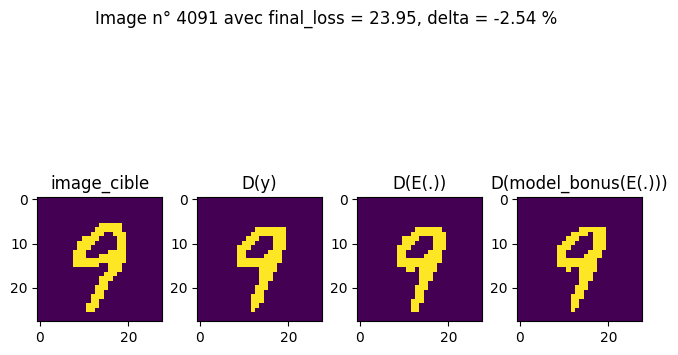

1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

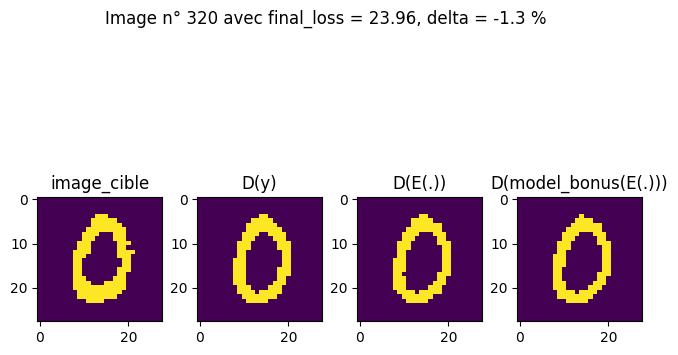

In [ ]:
import numpy as np

def indices_des_petits(L):
    """
    Find the indices of the two smallest values in a list or array.

    Args:
        L (list or array-like): A list or array of numerical values.

    Returns:
        list: Indices of the two smallest values in the input list or array.
    """
    # Ensure L is a Numpy array to use its sorting functions
    L_array = np.array(L)
    
    # Use np.argsort to get the indices that would sort the array
    indices_tries = np.argsort(L_array)
    
    # Select the indices of the two smallest elements
    indices_petits = indices_tries[999:1001]

    # Return the indices as a list
    return indices_petits.tolist()


if __name__ == "__main__":
    # Get the indices of the two smallest errors
    indices_petits = indices_des_petits(final_errors)
    
    # Save flag to control whether to save the comparison images
    save = False
    
    # Loop through the indices of the smallest errors and generate comparison images
    for index in indices_petits:
        file_name_comparison = f"comparison_image_{index}_errors.png"
        file_path_comparison = f"/content/drive/My Drive/Thesis/top_9_errors/{file_name_comparison}"
        
        # Call the comparison_images function to generate and save the images
        comparison_images(index, file_path_comparison, save)


In [ ]:
# Calculate the correlation between deltas and final_errors
correlation = np.corrcoef(deltas, final_errors)[0, 1]

# Print the calculated correlation value
print("Corrélation entre deltas et final_errors :", correlation)

# Interpret the correlation based on its strength
if correlation > 0.7:
    print("Il existe une forte corrélation positive entre deltas et final_errors")
elif correlation < -0.7:
    print("Il existe une forte corrélation négative entre deltas et final_errors")
else:
    print("Il n'existe pas de corrélation forte entre deltas et final_errors")


Corrélation entre deltas et final_errors : 0.17920843690471547
Il n'existe pas de corrélation forte entre deltas et final_errors


In [ ]:
MT_space = np.array(reparam_subset)  # Ancien espace latent
MN_space = np.array(solutions)  # Nouvel espace latent

# def decoding(latent_space):
#   list_decoded = []
#   for point in tqdm(latent_space):
#     y = tf.Variable(point)
#     new_image = decoder_function(y)
#     list_decoded.append(np.array(new_image))
#   return list_decoded

# X_decoded = np.array(decoding(MT_space))
# Y_decoded = np.array(decoding(MN_space))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(latent_dim):
    """
    Build a simple feedforward neural network for latent space transformation.

    Args:
        latent_dim (int): The dimensionality of the latent space.

    Returns:
        model (keras.Sequential): A compiled Keras model.
    """
    model = models.Sequential()
    
    # Input layer with the specified latent dimension
    model.add(layers.Input(shape=(latent_dim,)))
    
    # Two fully connected (Dense) layers with ReLU activation
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer with latent_dim neurons
    model.add(layers.Dense(latent_dim))
    
    return model

# Define the dimension of the latent space from MT_space
dim = len(MT_space[0])

# Build the bonus model with the latent space dimension
model_bonus = build_model(dim)

# Compile the model with Adam optimizer and mean squared error (MSE) loss function
model_bonus.compile(optimizer='adam', loss='mse')

# Fit the model using the MT_space as input and MN_space as target
model_bonus.fit(MT_space, MN_space, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
125/125 [==============================] - 2s 6ms/step - loss: 0.1867 - val_loss: 0.0145
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 3/100
125/125 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 5/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0119
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0142
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0110 - val_lo

1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

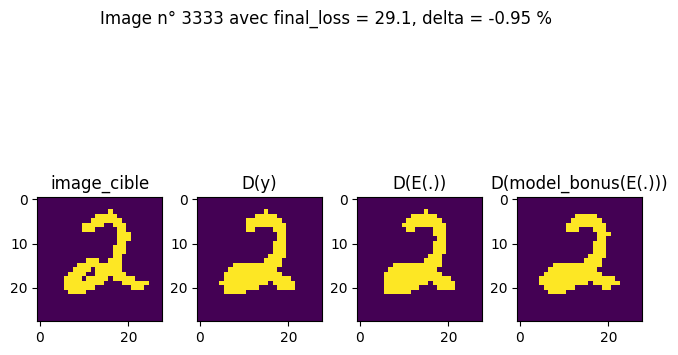

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files

def comparison_images(mnist_index, file_path_comparison='', save=False):
    """
    Generate and compare decoded images based on various latent space transformations.

    Args:
        mnist_index (int): Index of the MNIST image to compare.
        file_path_comparison (str): File path for saving the comparison image.
        save (bool): If True, saves and downloads the comparison image.
    """
    # Retrieve the target MNIST image
    image_cible = train_images[mnist_index, :, :, 0]
    
    # Retrieve the corresponding latent space solution
    y = tf.Variable(solutions[mnist_index])

    # Create a figure with constrained layout for better spacing
    plt.figure(constrained_layout=True)

    ####################################################################################################################################################
    # Plot 1: Original MNIST image (image_cible)
    ####################################################################################################################################################
    plt.subplot(1, 4, 1)
    plt.imshow(image_cible, cmap='gray')
    plt.title("Original Image")

    ####################################################################################################################################################
    # Plot 2: Decoded image from the latent space solution (D(y))
    ####################################################################################################################################################
    plt.subplot(1, 4, 2)
    dec_function_np = decoder_function(y)
    plt.imshow(np.where(dec_function_np > 0.5, 1.0, 0.0), cmap='gray')  # Binarize the image
    plt.title("D(y)")

    ####################################################################################################################################################
    # Plot 3: Decoded image from the encoder-decoder of the original image (D(E(image_cible)))
    ####################################################################################################################################################
    plt.subplot(1, 4, 3)
    dec_enc_image_cible = decoder_function(encoder_function(image_cible)).numpy()
    plt.imshow(np.where(dec_enc_image_cible > 0.5, 1.0, 0.0), cmap='gray')  # Binarize the image
    plt.title("D(E(.))")

    ####################################################################################################################################################
    # Plot 4: Decoded image after applying the bonus model to the encoded original image (D(model_bonus(E(.))))
    ####################################################################################################################################################
    plt.subplot(1, 4, 4)
    new_point = tf.squeeze(tf.Variable(model_bonus.predict(np.array([encoder_function(image_cible)]))))
    bonus = decoder_function(new_point).numpy()
    plt.imshow(np.where(bonus > 0.5, 1.0, 0.0), cmap='gray')  # Binarize the image
    plt.title("D(model_bonus(E(.)))")

    # Add a title summarizing the image number, final loss, and delta
    plt.suptitle(f"Image n° {mnist_index} with final_loss = {round(final_errors[mnist_index], 2)}, delta = {round(deltas[mnist_index], 2)} %")

    ####################################################################################################################################################
    # Save and display the comparison image
    ####################################################################################################################################################
    if save:
        plt.savefig(file_path_comparison)  # Save the image if requested
    
    plt.show()  # Display the comparison image

    # Download the saved image if requested
    if save:
        files.download(file_path_comparison)


# Example usage
if __name__ == "__main__":
    mnist_index = 3333  # Specify the index of the MNIST image to compare
    file_name_comparison = f"comparison_image_{mnist_index}.pdf"
    file_path_comparison = f"/content/drive/My Drive/Thesis/image_{mnist_index}/{file_name_comparison}"
    save = False  # Set to True if you want to save and download the comparison image
    
    comparison_images(mnist_index, file_path_comparison, save)


In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

def create_latent_bonus(number_images):
    """
    Generate latent space representations for a specified number of MNIST images using the bonus model.

    Args:
        number_images (int): The number of MNIST images to process.

    Returns:
        latent_bonus (list): A list of latent space representations after applying the bonus model.
    """
    latent_bonus = []
    
    # Loop through the specified number of MNIST images
    for mnist_index in tqdm(range(0, number_images)):
        # Retrieve the target MNIST image at mnist_index
        image_cible = train_images[mnist_index, :, :, 0]
        
        # Encode the image using the encoder and predict the new latent space with the bonus model
        new_point = tf.squeeze(tf.Variable(model_bonus.predict(np.array([encoder_function(image_cible)]))))
        
        # Append the latent space point to the list
        latent_bonus.append(new_point.numpy())
    
    return latent_bonus

if __name__ == "__main__":
    number_images = 5000  # Number of images to process
    
    # Generate latent space representations for the specified number of images
    # latent_bonus = create_latent_bonus(number_images)
    
    # Define the file path for saving the latent space points
    # filepath_bonus = '/content/drive/My Drive/Thesis/data/bonus.txt'
    
    # Save the latent space points to a file
    # create_list_sub_txt(latent_bonus, filepath_bonus)


In [ ]:
# Calculate the statistics for the latent_bonus space
mean_bonus, variance_bonus, correlation, covariance_matrix_bonus = calculate_stats(latent_bonus)

# Print the mean of the latent_bonus space
print(f"Mean of latent_bonus: {mean_bonus}")

# Optionally print the variance (uncomment if needed)
# print(f"Variance of latent_bonus: {variance_bonus}")

# Print the covariance matrix of the latent_bonus space
print(f"Covariance matrix of latent_bonus: \n{covariance_matrix_bonus}")

# Optionally print the correlation (uncomment if needed)
# print(f"Correlation between the two dimensions of latent_bonus: {correlation}")


Mean : [-0.12426448  0.04010271]
Covariance matrix : 
[[1.19467475 0.13671091]
 [0.13671091 1.33765635]]


In [ ]:
import numpy as np
from tqdm import tqdm

# Initialize lists to store deltas and distances
deltas_bonus = []

# Loop through the first 5000 images
for i in tqdm(range(5000)):
    # Decode the points for Pr. Turinici's latent space and bonus latent space
    point0 = decoder_function(tf.Variable(reparam[i]))  # From Pr. Turinici's latent space
    point1 = decoder_function(tf.Variable(latent_bonus[i]))  # From the bonus latent space
    
    # Retrieve the original MNIST image
    point2 = train_images[i, :, :, 0]
    
    # Calculate the Euclidean distances between the decoded points and the original image
    v_d = distance_euclidienne_np(point0, point2)  # Distance from Pr. Turinici's decoded space to the original image
    v_f = distance_euclidienne_np(point1, point2)  # Distance from bonus model's decoded space to the original image
    
    # Calculate the delta (percentage change in distance)
    deltas_bonus.append(((v_f - v_d) / v_d) * 100)

# Calculate the mean and variance of the deltas
mean_delta = np.mean(deltas_bonus)
variance_delta = np.var(deltas_bonus)

# Print the results
print(f"Mean of deltas between MT & MN: {mean_delta}")
print(f"Variance of deltas between MT & MN: {variance_delta}")


100%|██████████| 5000/5000 [00:50<00:00, 99.52it/s]

Mean of distance between MT & MN : 0.12033189817201219
Variance of distance between MT & MN: 10.83615313613396


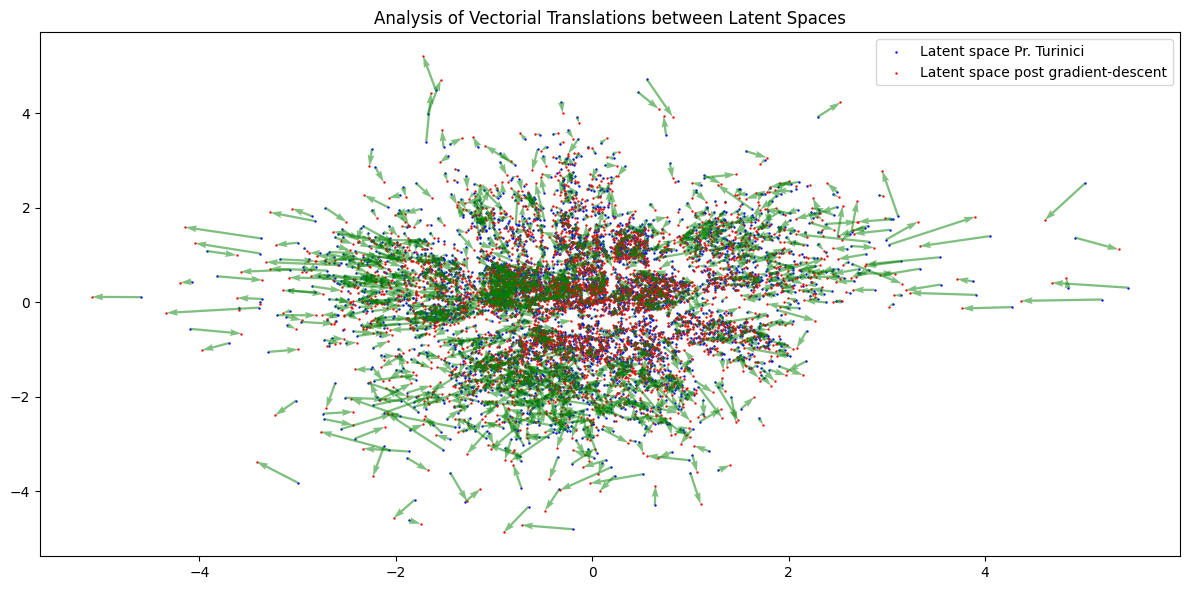

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the differences to obtain translation vectors between the two latent spaces
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

# Compute the translation vectors (dx, dy)
dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

# Create a figure for the plot
plt.figure(figsize=(12, 6))

####################################################################################################################################################
# Plot the points for the original latent space (Pr. Turinici's latent space)
####################################################################################################################################################
plt.scatter(new_reparam_subset[:, 0], new_reparam_subset[:, 1], s=0.5, color='blue', label="Latent space Pr. Turinici")

####################################################################################################################################################
# Plot the points for the new latent space (post-gradient-descent)
####################################################################################################################################################
plt.scatter(new_solutions[:, 0], new_solutions[:, 1], s=0.5, color='red', label="Latent space post gradient-descent")

####################################################################################################################################################
# Plot the translation vectors between the original and new latent spaces
####################################################################################################################################################
plt.quiver(new_reparam_subset[:, 0], new_reparam_subset[:, 1], dx, dy, angles='xy', scale_units='xy', scale=1, width=0.002, alpha=0.5, color='green')

# Add a title and legend to the plot
plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.legend()
plt.tight_layout()

####################################################################################################################################################
# Save and display the plot
####################################################################################################################################################
path_location = '/content/drive/My Drive/Thesis/latent_spaces/vectorial_analysis.pdf'

# Save the plot as a PDF
plt.savefig(path_location)

# Display the plot
plt.show()

####################################################################################################################################################
# Download the file (if using Google Colab)
####################################################################################################################################################
files.download(path_location)


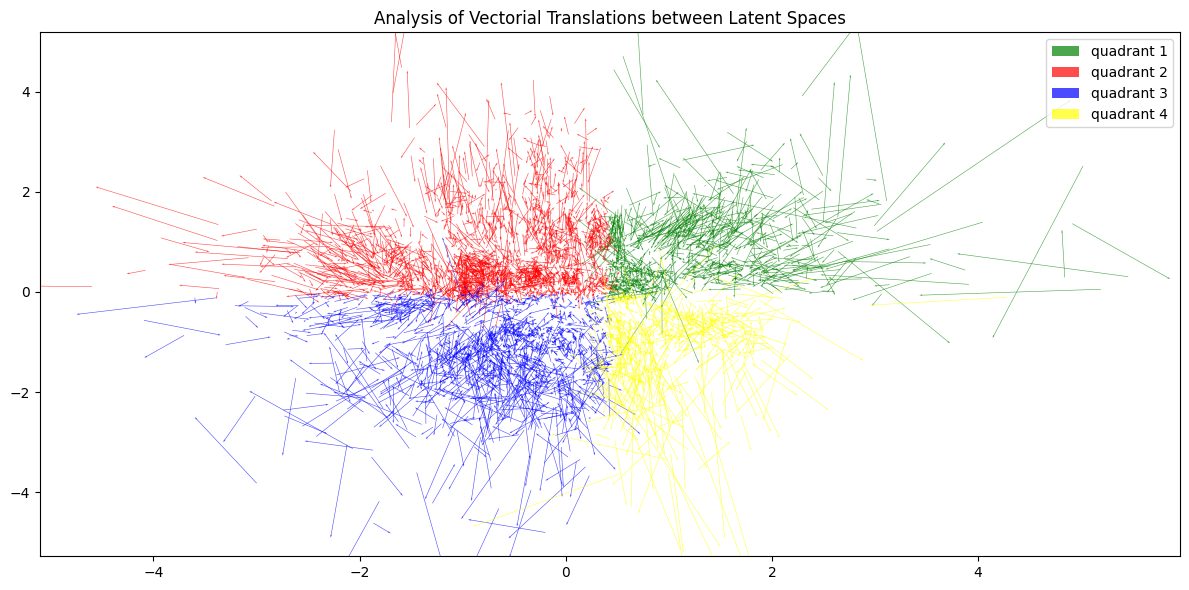

In [ ]:
# Supposons que new_reparam_subset et new_solutions soient déjà définis
# Conversion en array NumPy pour une manipulation aisée
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

# Calcul des vecteurs de translation
dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

# Déterminer le centre de l'espace
centre_x = (new_reparam_subset[:, 0].min() + new_reparam_subset[:, 0].max()) / 2
centre_y = (new_reparam_subset[:, 1].min() + new_reparam_subset[:, 1].max()) / 2

# Fonction pour déterminer le quadrant
def determine_quadrant(x, y):
    if x > centre_x and y > centre_y:
        return 'quadrant 1'
    elif x < centre_x and y > centre_y:
        return 'quadrant 2'
    elif x < centre_x and y < centre_y:
        return 'quadrant 3'
    else:
        return 'quadrant 4'

# Attribuer chaque point à un quadrant
quadrants = np.array([determine_quadrant(x, y) for x, y in zip(new_reparam_subset[:, 0], new_reparam_subset[:, 1])])

plt.figure(figsize=(12, 6))

# Couleurs pour chaque quadrant
colors = {'quadrant 1': 'green', 'quadrant 2': 'red', 'quadrant 3': 'blue', 'quadrant 4': 'yellow'}

# Tracer les flèches pour chaque quadrant
for quadrant in np.unique(quadrants):
    idx = np.where(quadrants == quadrant)
    plt.quiver(new_reparam_subset[idx, 0], new_reparam_subset[idx, 1], dx[idx], dy[idx],
               color=colors[quadrant], width=0.0005, alpha=0.7, label=quadrant)

plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.legend()
plt.tight_layout()
# Pour sauvegarder le plot
path_location = '/content/drive/My Drive/Thesis/latent_spaces/vectorial_analysis_quadrant.pdf'
#plt.savefig(path_location)
plt.show()
# Pour télécharger le fichier si vous utilisez Google Colab
#files.download(path_location)

100%|██████████| 5000/5000 [01:16<00:00, 64.94it/s]


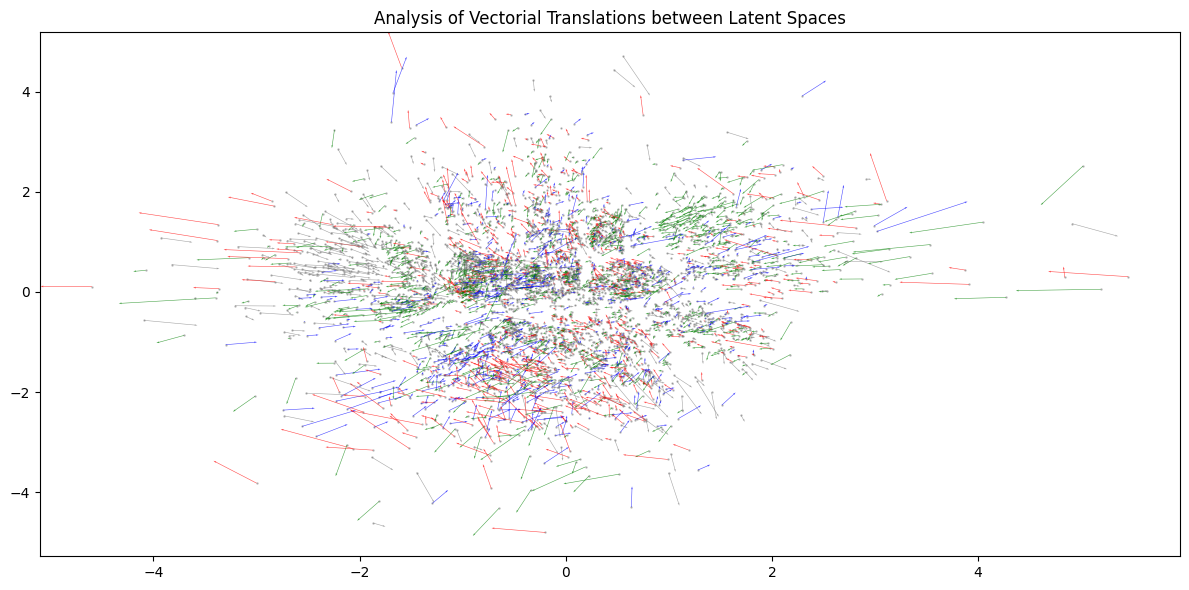

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Supposons que new_reparam_subset et new_solutions soient déjà définis
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

# Calcul des vecteurs de translation
dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

plt.figure(figsize=(12, 6))

# Tracé du nuage de points de départ pour le contexte
plt.scatter(new_reparam_subset[:, 0], new_reparam_subset[:, 1], s=0.5, color='gray', alpha=0.5)

# Couleurs en fonction de la direction
colors = np.where((dx > 0) & (dy > 0), 'blue',  # Haut-droite
                  np.where((dx < 0) & (dy > 0), 'red',  # Haut-gauche
                           np.where((dx < 0) & (dy < 0), 'green', 'grey')))  # Bas-gauche et Bas-droit

# Tracé des flèches avec les couleurs appropriées pour chaque direction
for i in tqdm(range(len(dx))):
    plt.quiver(new_reparam_subset[i, 0], new_reparam_subset[i, 1], dx[i], dy[i],
               color=colors[i], angles='xy', scale_units='xy', scale=1, width=0.0005, alpha=0.7)

plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.tight_layout()
# Pour sauvegarder le plot
path_location = '/content/drive/My Drive/Thesis/latent_spaces/vectorial_analysis_quadrant_final.pdf'
plt.savefig(path_location)
plt.show()
# Pour télécharger le fichier si vous utilisez Google Colab
files.download(path_location)

100%|██████████| 5000/5000 [01:24<00:00, 59.03it/s]


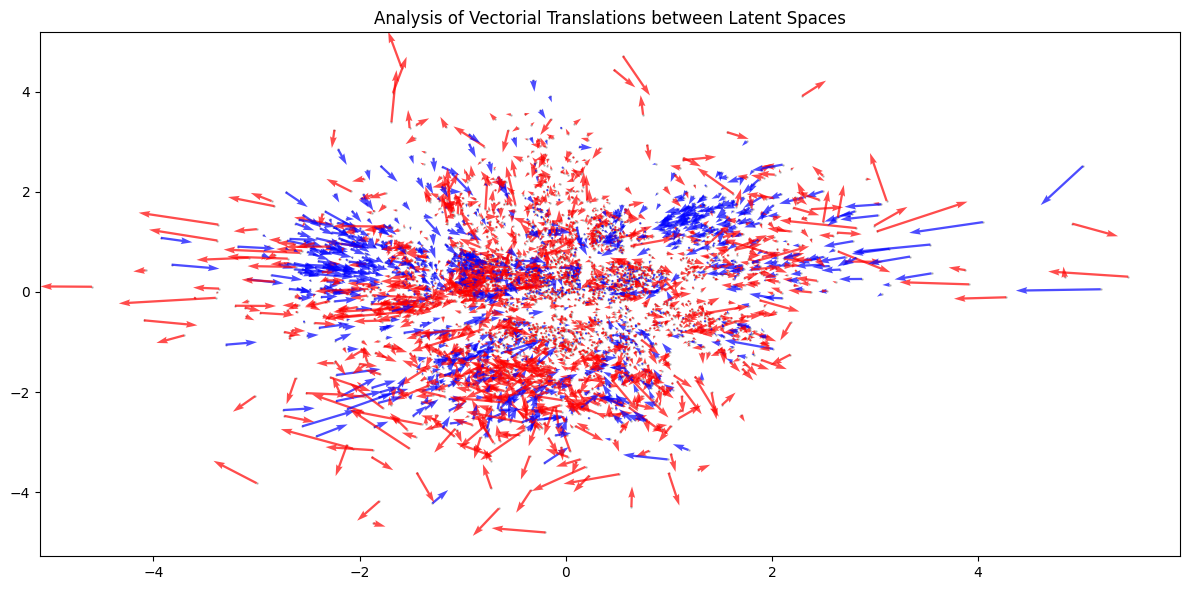

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Combinaison

import matplotlib.pyplot as plt
import numpy as np

# Supposons que new_reparam_subset et new_solutions soient déjà définis
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

# Calcul des vecteurs de translation
dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

# Déterminer le centre de l'espace
centre_x = (new_reparam_subset[:, 0].min() + new_reparam_subset[:, 0].max()) / 2
centre_y = (new_reparam_subset[:, 1].min() + new_reparam_subset[:, 1].max()) / 2

# Fonction pour déterminer le quadrant
def determine_quadrant(x, y):
    if x > centre_x and y > centre_y:
        return 'quadrant 1'
    elif x < centre_x and y > centre_y:
        return 'quadrant 2'
    elif x < centre_x and y < centre_y:
        return 'quadrant 3'
    else:
        return 'quadrant 4'

# Attribuer chaque point à un quadrant
quadrants = np.array([determine_quadrant(x, y) for x, y in zip(new_reparam_subset[:, 0], new_reparam_subset[:, 1])])

# Déterminer la couleur de chaque flèche en fonction de la direction et du quadrant
colors = []
for i, quadrant in enumerate(quadrants):
    if quadrant == 'quadrant 1':
        color = 'blue' if dx[i] < 0 and dy[i] < 0 else 'red'
    elif quadrant == 'quadrant 4':
        color = 'blue' if dx[i] < 0 and dy[i] > 0 else 'red'
    elif quadrant == 'quadrant 2':
        color = 'blue' if dx[i] > 0 and dy[i] < 0 else 'red'
    elif quadrant == 'quadrant 3':
        color = 'blue' if dx[i] > 0 and dy[i] > 0 else 'red'
    colors.append(color)

plt.figure(figsize=(12, 6))

# Tracé du nuage de points de départ pour le contexte
plt.scatter(new_reparam_subset[:, 0], new_reparam_subset[:, 1], s=0.5, color='gray', alpha=0.5)

# Tracé des flèches avec les couleurs appropriées pour chaque direction
for i in tqdm(range(len(dx))):
    plt.quiver(new_reparam_subset[i, 0], new_reparam_subset[i, 1], dx[i], dy[i],
               color=colors[i], angles='xy', scale_units='xy', scale=1, width=0.002, alpha=0.7)

plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.tight_layout()
# Pour sauvegarder le plot
path_location = '/content/drive/My Drive/Thesis/latent_spaces/vectorial_analysis_clement.pdf'
plt.savefig(path_location)
plt.show()
# Pour télécharger le fichier si vous utilisez Google Colab
files.download(path_location)

100%|██████████| 5000/5000 [00:57<00:00, 86.81it/s]


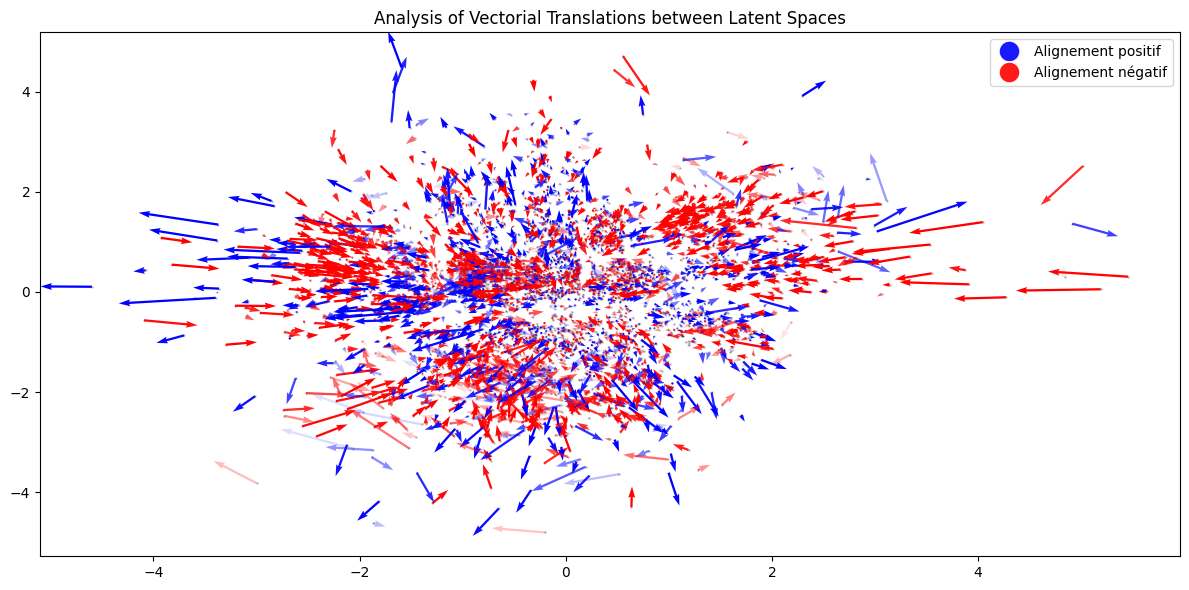

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Supposons que new_reparam_subset et new_solutions soient déjà définis
new_reparam_subset = np.array(reparam_subset)
new_solutions = np.array(solutions)

new_mean = np.array([-0.123, 0.0281])

# Calcul des vecteurs
vecteurs_mean_to_reparam = new_reparam_subset - new_mean
vecteurs_reparam_to_solutions = new_solutions - new_reparam_subset

dx = new_solutions[:, 0] - new_reparam_subset[:, 0]
dy = new_solutions[:, 1] - new_reparam_subset[:, 1]

# Normalisation des vecteurs pour le calcul du produit scalaire
norm_vecteurs_mean_to_reparam = vecteurs_mean_to_reparam / np.linalg.norm(vecteurs_mean_to_reparam, axis=1, keepdims=True)
norm_vecteurs_reparam_to_solutions = vecteurs_reparam_to_solutions / np.linalg.norm(vecteurs_reparam_to_solutions, axis=1, keepdims=True)

# Calcul du produit scalaire entre les vecteurs normalisés
produit_scalaire = np.sum(norm_vecteurs_mean_to_reparam * norm_vecteurs_reparam_to_solutions, axis=1)

plt.figure(figsize=(12, 6))

# Tracé du nuage de points de départ pour le contexte
plt.scatter(new_reparam_subset[:, 0], new_reparam_subset[:, 1], s=0.5, color='gray', alpha=0.5)

# Normalisation des valeurs de produit_scalaire pour l'opacité
# L'opacité varie de 0.1 à 1.0 en fonction de la valeur absolue du produit scalaire normalisée
alpha_values = np.abs(produit_scalaire) / np.max(np.abs(produit_scalaire))
alpha_values = 0.1 + 0.9 * alpha_values  # Assurer un minimum de 0.1 pour la visibilité

for i in tqdm(range(len(dx))):
    # Déterminer la couleur en fonction du signe du produit scalaire
    color = 'blue' if produit_scalaire[i] > 0 else 'red'

    plt.quiver(new_reparam_subset[i, 0], new_reparam_subset[i, 1], dx[i], dy[i],
               color=color, alpha=alpha_values[i], angles='xy', scale_units='xy', scale=1, width=0.002)

# Création de la légende
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, alpha=0.9, label='Alignement positif'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, alpha=0.9, label='Alignement négatif')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.title("Analysis of Vectorial Translations between Latent Spaces")
plt.tight_layout()
path_location = '/content/drive/My Drive/Thesis/latent_spaces/vectorial_analysis_greg.pdf'
plt.savefig(path_location)
plt.show()
# Pour télécharger le fichier si vous utilisez Google Colab
files.download(path_location)